# Архитектуры тестируемых моделей нейросетей (скорее всего сделать в виде обычного файла .py)

https://github.com/muhanzhang/pytorch_DGCNN

* https://arxiv.org/abs/1812.08434v4
* https://github.com/ShiYaya/graph


На основе https://arxiv.org/pdf/1606.09375.pdf

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import pdb
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()

import os
import time
import numpy as np
#import scipy
from scipy import sparse 
from scipy.sparse import linalg
#from tqdm.auto import tqdm
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

In [3]:
import collections

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

cuda not available
device = cpu


X – coordinates

A – adjacency matrices

y – cad-scores

**DATA format: {target_name}, {model_name}, {coordinates}, {adjacency_matrix}, {cad-score}**

In [4]:
DATA = np.load('./data.npy', allow_pickle=True)

In [6]:
a = DATA[:, 0] == 'T0861'
b = DATA[:, 1] == 'chuo-u-server_TS2'
sum(np.logical_and(a, b))

1

In [7]:
DATA_permuted = np.random.permutation(DATA)

In [8]:
a = DATA_permuted[:, 0] == 'T0861'
b = DATA_permuted[:, 1] == 'chuo-u-server_TS2'
sum(np.logical_and(a, b))

1

In [9]:
print(DATA_permuted[:, 0])

['T0859' 'T0866' 'T0865' 'T0859' 'T0866' 'T0860' 'T0860' 'T0859' 'T0861'
 'T0859' 'T0859' 'T0859' 'T0866' 'T0860' 'T0859' 'T0859' 'T0864' 'T0866'
 'T0861' 'T0859' 'T0859' 'T0859' 'T0860' 'T0860' 'T0859' 'T0864' 'T0861'
 'T0860' 'T0860' 'T0860' 'T0859' 'T0859' 'T0862' 'T0860' 'T0866' 'T0859'
 'T0864' 'T0865' 'T0860' 'T0864' 'T0862' 'T0864' 'T0862' 'T0866' 'T0859'
 'T0862' 'T0859' 'T0859' 'T0866' 'T0860' 'T0860' 'T0859' 'T0859' 'T0859'
 'T0864' 'T0859' 'T0859' 'T0859' 'T0859' 'T0862' 'T0859' 'T0866' 'T0859'
 'T0861' 'T0864' 'T0859' 'T0859' 'T0859' 'T0859' 'T0859' 'T0859' 'T0866'
 'T0859' 'T0859' 'T0864' 'T0859' 'T0859' 'T0866' 'T0859' 'T0862' 'T0861'
 'T0859' 'T0860' 'T0859' 'T0862' 'T0860' 'T0860' 'T0859' 'T0859' 'T0861'
 'T0859' 'T0864' 'T0859' 'T0859' 'T0859' 'T0861' 'T0862' 'T0859' 'T0866'
 'T0865' 'T0859' 'T0860' 'T0860' 'T0864' 'T0859' 'T0859' 'T0859' 'T0862'
 'T0859' 'T0866' 'T0864' 'T0866' 'T0862' 'T0859' 'T0859' 'T0864' 'T0864'
 'T0862' 'T0859' 'T0859' 'T0859' 'T0859' 'T0862' 'T

In [227]:
DATA_859 = DATA[:104]

In [228]:
X_859 = DATA_859[:, 2]

In [229]:
indices_where988 = [i for i in range(len(X_859)) if X_859[i].shape[0] == 988]
newData = DATA_859[indices_where988]

In [380]:
newData_permut = np.random.permutation(newData)

In [13]:
'''
separator = 200

names_train = DATA_permuted[:separator, :2]
X_train = DATA_permuted[:separator, 2]
A_train = DATA_permuted[:separator, 3]
y_train = DATA_permuted[:separator, 4]

names_test =DATA_permuted[separator:, :2]
X_test = DATA_permuted[separator:, 2]
A_test = DATA_permuted[separator:, 3]
y_test = DATA_permuted[separator:, 4]
'''

separator = 60

names_train = newData[:separator, :2]
X_train = newData[:separator, 2]
A_train = newData[:separator, 3]
y_train = newData[:separator, 4]

names_test = newData[separator:, :2]
X_test = newData[separator:, 2]
A_test = newData[separator:, 3]
y_test = newData[separator:, 4]

print('train: {}\ntest: {}'.format(X_train.shape[0], X_test.shape[0]))

train: 60
test: 9


In [14]:
len(X_train[0])

988

In [15]:
def laplacian(A):
    '''
    A - adjacency matrix
    d - degree matrix 
    Return graph Laplacian
    '''
    d = A.sum(axis=0)
    d += np.spacing(np.array(0, A.dtype)) # добавление epsilon
    d = 1 / np.sqrt(d)
    D = sparse.diags(d.squeeze(), 0)
    I = sparse.identity(d.size, dtype=A.dtype)
    L = I - D * A * D

    assert np.abs(L - L.T).mean() < 1e-9
    #assert type(L) is sparse.csr.csr_matrix
    return L.A

def lmax_L(L):
    """Compute largest Laplacian eigenvalue"""
    return linalg.eigsh(L, k=1, which='LM', return_eigenvectors=False)[0]

# L с волной
def rescale_L(L, lmax=2):
    """Rescale Laplacian eigenvalues to [-1,1]"""
    M, M = L.shape
    I = sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax
    L *= 2
    L -= I
    return L.A

In [16]:
%%time
test_adj = A_train[0]
L = laplacian(test_adj)
l_max = lmax_L(L)
L_hat = rescale_L(L, l_max)

CPU times: user 370 ms, sys: 42.4 ms, total: 412 ms
Wall time: 276 ms


In [17]:
l_max

1.3604276050662507

Получившаяся матрица сильно разреженная. Ненулевых элементов ~1-2%:

In [18]:
not_zero = sum(sum(L_hat != 0))
total = len(L_hat)**2
print('Ненулевых элементов: {}\nВсего элементов в матрице: {}'.format(not_zero, total))
print(str(round(100 * not_zero / total, 3)) + '%')

Ненулевых элементов: 16942
Всего элементов в матрице: 976144
1.736%


In [19]:
X_train[0].shape

(988, 3)

In [254]:
# NN layers and models
class GraphConv(nn.Module):
    '''
    Graph Convolution Layer according to (T. Kipf and M. Welling, ICLR 2017)
    Additional tricks (power of adjacency matrix and weight self connections) as in the Graph U-Net paper
    '''
    def __init__(self,
                in_features,
                out_features,
                activation=None,
                adj_sq=False,
                scale_identity=False):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_features=in_features, out_features=out_features).double()
        self.adj_sq = adj_sq
        self.activation = activation
        self.scale_identity = scale_identity
            
    def laplacian_batch(self, A):
        
        batch, N = A.shape[:2]
        if self.adj_sq:
            A = torch.bmm(A, A)  # use A^2 to increase graph connectivity
        I = torch.eye(N).unsqueeze(0).double().to(device)
        if self.scale_identity:
            I = 2 * I  # increase weight of self connections
        A_hat = A + I
        D_hat = (torch.sum(A_hat, 1) + 1e-5) ** (-0.5)
        #print('-'*40)
        #print(batch)
        #print(A_hat.shape)
        #print(D_hat.shape)
        #print(D_hat.view(batch, N, 1).shape)
        #print('-'*40)
        L = D_hat.view(batch, N, 1) * A_hat * D_hat.view(batch, 1, N)
        return L

    def forward(self, data):
        x, A = data
        
        a = torch.bmm(self.laplacian_batch(A), x)
        x = self.fc(a.double())
        if self.activation is not None:
            x = self.activation(x)
        return (x, A)
        
class GCN(nn.Module):
    '''
    Baseline Graph Convolutional Network with a stack of Graph Convolution Layers and global pooling over nodes.
    '''
    def __init__(self,
                 in_features,
                 out_features,
                 filters=[64,64,64],
                 n_hidden=0,
                 dropout=0.2,
                 adj_sq=False,
                 scale_identity=False):
        super(GCN, self).__init__()

        # Graph convolution layers
        self.gconv = nn.Sequential(*([GraphConv(in_features=in_features if layer == 0 else filters[layer - 1], 
                                                out_features=f, 
                                                activation=nn.ReLU(inplace=True),
                                                adj_sq=adj_sq,
                                                scale_identity=scale_identity) for layer, f in enumerate(filters)]))
        
        # Fully connected layers
        fc = []
        if dropout > 0:
            fc.append(nn.Dropout(p=dropout))
        if n_hidden > 0:
            fc.append(nn.Linear(filters[-1], n_hidden))
            if dropout > 0:
                fc.append(nn.Dropout(p=dropout))
            n_last = n_hidden
        else:
            n_last = filters[-1]
        fc.append(nn.Linear(n_last, out_features))       
        self.fc = nn.Sequential(*fc).double()
        
    def forward(self, data):
        # X, A = data
        x = self.gconv(data)[0]
        x = torch.max(x, dim=1)[0].squeeze()  # max pooling over nodes
        x = self.fc(x)
        return x 

In [381]:
model = GCN(in_features=3,
            out_features=1,
            n_hidden=0,
            filters=[64,64,64],
            dropout=0.2,
            adj_sq=False,
            scale_identity=False).to(device)

In [343]:
'''
datareader = DataReader(data_dir='./data/%s/' % dataset.upper(),
                        rnd_state=np.random.RandomState(seed),
                        folds=n_folds,                    
                        use_cont_node_attr=False)

for split in ['train', 'test']:
        gdata = GraphData(fold_id=fold_id,
                          datareader=datareader,
                          split=split)

        loader = torch.utils.data.DataLoader(gdata, 
                                             batch_size=batch_size,
                                             shuffle=split.find('train') >= 0,
                                             num_workers=threads)
        loaders.append(loader)
'''

"\ndatareader = DataReader(data_dir='./data/%s/' % dataset.upper(),\n                        rnd_state=np.random.RandomState(seed),\n                        folds=n_folds,                    \n                        use_cont_node_attr=False)\n\nfor split in ['train', 'test']:\n        gdata = GraphData(fold_id=fold_id,\n                          datareader=datareader,\n                          split=split)\n\n        loader = torch.utils.data.DataLoader(gdata, \n                                             batch_size=batch_size,\n                                             shuffle=split.find('train') >= 0,\n                                             num_workers=threads)\n        loaders.append(loader)\n"

In [344]:
wdecay = 1e-4
epochs = 15
lr = 0.005
batch_size = 5

In [382]:

#train_data = [list(DATA_859[:90][i]) for i in range(len(DATA_859[:90]))]
#test_data = [list(DATA_859[90:][i]) for i in range(len(DATA_859[90:]))]

train_data = [list(newData_permut[:separator][i]) for i in range(len(newData_permut[:separator]))]
test_data = [list(newData_permut[separator:][i]) for i in range(len(newData_permut[separator:]))]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [318]:
for batch_idx, data in enumerate(train_loader):
    if batch_idx==0:
        print(data[1])

('HHGG_TS4', 'GAPF_LNCC_SERVER_TS4', 'MULTICOM-CONSTRUCT_TS1', 'Distill_TS2', 'FLOUDAS_SERVER_TS1')


In [383]:
print('\nInitialize model')
print(model)
epochs = 10


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    weight_decay=wdecay,
    betas=(0.5, 0.999))
    
scheduler = lr_scheduler.MultiStepLR(optimizer, [20, 30], gamma=0.1)


def train(train_loader):
    scheduler.step()
    model.train()
    start = time.time()
    train_loss_ep = []
    n_samples = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()

        output = model(data[2:4])
        loss = loss_fn(output, data[4])
        loss.backward()
        optimizer.step()
        time_iter = time.time() - start
        train_loss_ep.append(loss.item())
        n_samples += len(output)

        if batch_idx%2==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (avg: {:.6f}) \tsec/iter: {:.4f}'.format(
                epoch, n_samples, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(), sum(train_loss_ep) / n_samples, time_iter / (batch_idx + 1) ))

    return train_loss_ep


def test(test_loader):
    model.eval()
    start = time.time()
    test_loss_ep = []
    correct, n_samples = 0, 0
    for batch_idx, data in enumerate(test_loader):
        #for i in range(len(data)):
        #    data[i] = data[i].to(device)
       
        
        output = model(data[2:4])
        loss = loss_fn(output, data[4])
        test_loss_ep.append(loss.item())
        n_samples += len(output)
        #pred = output.detach().cpu().max(1, keepdim=True)[1]

        #correct += pred.eq(data[4].detach().cpu().view_as(pred)).sum().item()

    time_iter = time.time() - start

    #test_loss /= n_samples

    #acc = 100. * correct / n_samples
    print('Test set (epoch {}): Mean loss: {:.4f}\n'.format(epoch, 
                                                                                          np.mean(test_loss_ep)
                                                                                              #correct, 
                                                                                              ))
    return test_loss_ep

loss_fn = torch.nn.MSELoss()
mse_train_plot, mse_test_plot = [], []
for epoch in range(epochs):
    train_loss = train(train_loader)
    mse_train_plot.append(train_loss)
    test_loss = test(test_loader)
    mse_test_plot.append(test_loss)
    


Initialize model
GCN(
  (gconv): Sequential(
    (0): GraphConv(
      (fc): Linear(in_features=3, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
    )
    (1): GraphConv(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
    )
    (2): GraphConv(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
    )
  )
  (fc): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)
Train Epoch: 0 [5/60 (8%)]	Loss: 1.065127 (avg: 0.213025) 	sec/iter: 0.3499
Train Epoch: 0 [15/60 (25%)]	Loss: 1.301589 (avg: 0.545962) 	sec/iter: 0.3626
Train Epoch: 0 [25/60 (42%)]	Loss: 1.196344 (avg: 0.557684) 	sec/iter: 0.3643
Train Epoch: 0 [35/60 (58%)]	Loss: 5.568241 (avg: 0.566236) 	sec/iter: 0.3427
Train Epoch: 0 [45/60 (75%)]	Loss: 0.579070 (avg: 0.526445) 	sec/iter: 0.3349
Train Epoch: 0 [55/60 (92%)]	Loss: 0.161017 (avg: 0.442

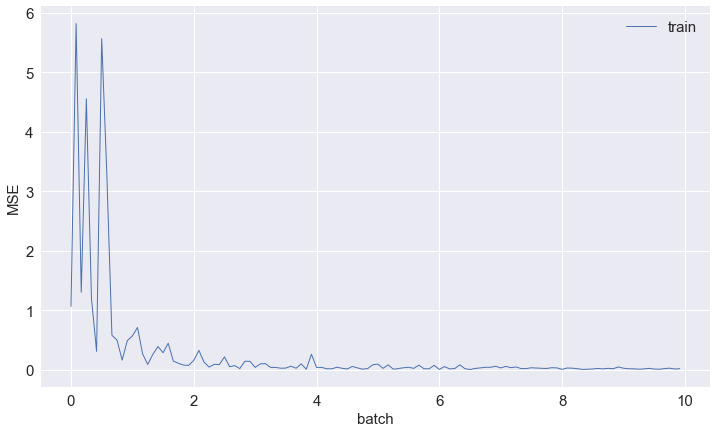

In [384]:
tr = np.array(mse_train_plot).flatten()
plt.figure(figsize=(12, 7))
plt.plot(np.arange(len(tr))/12, tr, lw=1, linestyle='-', label='train')


plt.xlabel('batch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})
plt.show()

In [391]:
(np.arange(len(tr))+1)/12

array([ 0.08333333,  0.16666667,  0.25      ,  0.33333333,  0.41666667,
        0.5       ,  0.58333333,  0.66666667,  0.75      ,  0.83333333,
        0.91666667,  1.        ,  1.08333333,  1.16666667,  1.25      ,
        1.33333333,  1.41666667,  1.5       ,  1.58333333,  1.66666667,
        1.75      ,  1.83333333,  1.91666667,  2.        ,  2.08333333,
        2.16666667,  2.25      ,  2.33333333,  2.41666667,  2.5       ,
        2.58333333,  2.66666667,  2.75      ,  2.83333333,  2.91666667,
        3.        ,  3.08333333,  3.16666667,  3.25      ,  3.33333333,
        3.41666667,  3.5       ,  3.58333333,  3.66666667,  3.75      ,
        3.83333333,  3.91666667,  4.        ,  4.08333333,  4.16666667,
        4.25      ,  4.33333333,  4.41666667,  4.5       ,  4.58333333,
        4.66666667,  4.75      ,  4.83333333,  4.91666667,  5.        ,
        5.08333333,  5.16666667,  5.25      ,  5.33333333,  5.41666667,
        5.5       ,  5.58333333,  5.66666667,  5.75      ,  5.83

In [394]:
((np.arange(len(tr))+1)/12)

array([ 0.08333333,  0.16666667,  0.25      ,  0.33333333,  0.41666667,
        0.5       ,  0.58333333,  0.66666667,  0.75      ,  0.83333333,
        0.91666667,  1.        ,  1.08333333,  1.16666667,  1.25      ,
        1.33333333,  1.41666667,  1.5       ,  1.58333333,  1.66666667,
        1.75      ,  1.83333333,  1.91666667,  2.        ,  2.08333333,
        2.16666667,  2.25      ,  2.33333333,  2.41666667,  2.5       ,
        2.58333333,  2.66666667,  2.75      ,  2.83333333,  2.91666667,
        3.        ,  3.08333333,  3.16666667,  3.25      ,  3.33333333,
        3.41666667,  3.5       ,  3.58333333,  3.66666667,  3.75      ,
        3.83333333,  3.91666667,  4.        ,  4.08333333,  4.16666667,
        4.25      ,  4.33333333,  4.41666667,  4.5       ,  4.58333333,
        4.66666667,  4.75      ,  4.83333333,  4.91666667,  5.        ,
        5.08333333,  5.16666667,  5.25      ,  5.33333333,  5.41666667,
        5.5       ,  5.58333333,  5.66666667,  5.75      ,  5.83

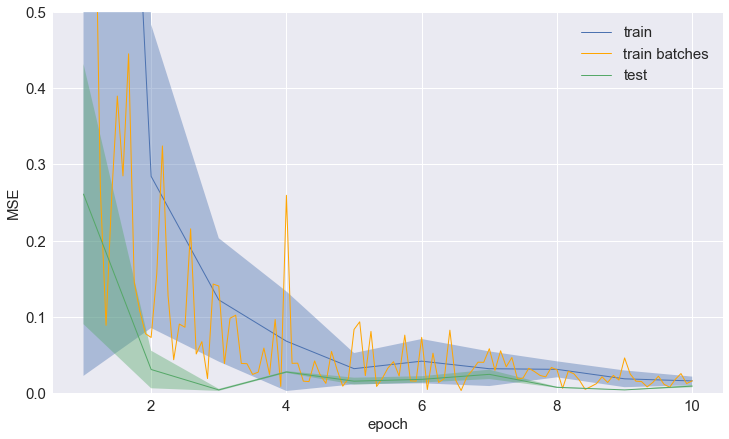

In [402]:
tr = np.array(mse_train_plot).flatten()

plt.figure(figsize=(12, 7))
axes = plt.gca()
axes.set_ylim([0,0.5])

plt.plot((np.arange(10)+1), np.mean(mse_train_plot,1), lw=1, linestyle='-', label='train')
plt.fill_between((np.arange(10)+1), np.mean(mse_train_plot, 1)  + np.std(mse_train_plot, 1) , 
                 np.mean(mse_train_plot, 1) - np.std(mse_train_plot, 1), 
                 alpha = 0.4)


plt.plot(((np.arange(len(tr))+1)/12)[12:], tr[12:], lw=1, linestyle='-', label='train batches', color='orange')

#plt.plot(np.arange(25), np.mean(mse_test_plot,1), lw=1, linestyle='-', label='test')
#plt.fill_between(np.arange(25), np.mean(mse_test_plot, 1)  + np.std(mse_test_plot, 1) , 
#                 np.mean(mse_test_plot, 1) - np.std(mse_test_plot, 1), 
#                 alpha = 0.4 )

plt.plot((np.arange(10)+1), np.mean(mse_test_plot,1), lw=1, linestyle='-', label='test') 
plt.fill_between((np.arange(10)+1), np.mean(mse_test_plot, 1)  + np.std(mse_test_plot, 1) , 
                 np.mean(mse_test_plot, 1) - np.std(mse_test_plot, 1), 
                 alpha = 0.4 )

plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})
plt.show()



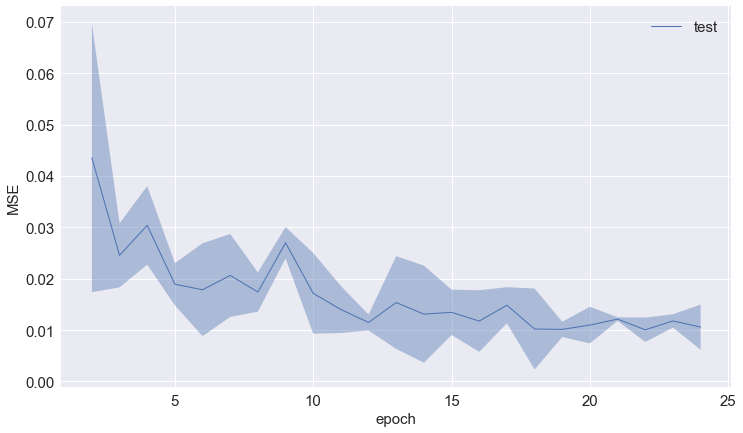

In [321]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(23)+2, np.mean(mse_test_plot[2:],1), lw=1, linestyle='-', label='test') 
plt.fill_between(np.arange(23)+2, np.mean(mse_test_plot[2:], 1)  + np.std(mse_test_plot[2:], 1) , 
                 np.mean(mse_test_plot[2:], 1) - np.std(mse_test_plot[2:], 1), 
                 alpha = 0.4 )

plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})
plt.show()



## Graph_ConvNet_LeNet5

In [152]:
from torch.utils.data import TensorDataset, DataLoader

In [204]:
class Graph_ConvNet_LeNet5(nn.Module):
    
    def __init__(self, net_parameters):
        
        print('Graph ConvNet: LeNet5')
        
        super(Graph_ConvNet_LeNet5, self).__init__()
        
        # parameters
        D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F = net_parameters
        D = X_train[0].shape[0]
        FC1Fin = CL2_F*(D//16)
        
        # graph CL1
        self.cl1 = nn.Linear(CL1_K, CL1_F) 
        Fin = CL1_K; Fout = CL1_F;
        scale = np.sqrt( 2.0/ (Fin+Fout) )
        self.cl1.weight.data.uniform_(-scale, scale)
        self.cl1.bias.data.fill_(0.0)
        self.CL1_K = CL1_K; self.CL1_F = CL1_F; 
        
        # graph CL2
        self.cl2 = nn.Linear(CL2_K*CL1_F, CL2_F) 
        Fin = CL2_K*CL1_F; Fout = CL2_F;
        scale = np.sqrt( 2.0/ (Fin+Fout) )
        self.cl2.weight.data.uniform_(-scale, scale)
        self.cl2.bias.data.fill_(0.0)
        self.CL2_K = CL2_K; self.CL2_F = CL2_F; 

        # FC1
        self.fc1 = nn.Linear(FC1Fin, FC1_F) 
        Fin = FC1Fin; Fout = FC1_F;
        scale = np.sqrt( 2.0/ (Fin+Fout) )
        self.fc1.weight.data.uniform_(-scale, scale)
        self.fc1.bias.data.fill_(0.0)
        self.FC1Fin = FC1Fin
        
        # FC2
        self.fc2 = nn.Linear(FC1_F, FC2_F)
        Fin = FC1_F; Fout = FC2_F;
        scale = np.sqrt( 2.0/ (Fin+Fout) )
        self.fc2.weight.data.uniform_(-scale, scale)
        self.fc2.bias.data.fill_(0.0)

        # nb of parameters
        nb_param = CL1_K * CL1_F + CL1_F          # CL1
        nb_param += CL2_K * CL1_F * CL2_F + CL2_F # CL2
        nb_param += FC1Fin * FC1_F + FC1_F        # FC1
        nb_param += FC1_F * FC2_F + FC2_F         # FC2
        print('nb of parameters=',nb_param,'\n')
        
        
    def init_weights(self, W, Fin, Fout):

        scale = np.sqrt( 2.0/ (Fin+Fout) )
        W.uniform_(-scale, scale)

        return W
        
        
    def graph_conv_cheby(self, x, cl, L, lmax, Fout, K):

        # parameters
        # B = batch size
        # V = nb vertices
        # Fin = nb input features
        # Fout = nb output features
        # K = Chebyshev order & support size
        B, V, Fin = x.size(); B, V, Fin = int(B), int(V), int(Fin) 

        # rescale Laplacian
        lmax = lmax_L(L)
        L = rescale_L(L, lmax) 
        
        # convert scipy sparse matric L to pytorch
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col)).T 
        indices = indices.astype(np.int64)
        indices = torch.from_numpy(indices)
        indices = indices.type(torch.LongTensor)
        L_data = L.data.astype(np.float32)
        L_data = torch.from_numpy(L_data) 
        L_data = L_data.type(torch.FloatTensor)
        L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
        L = Variable( L , requires_grad=False)
        if torch.cuda.is_available():
            L = L.cuda()
        
        # transform to Chebyshev basis
        x0 = x.permute(1,2,0).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])            # V x Fin*B
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B
        
        def concat(x, x_):
            x_ = x_.unsqueeze(0)            # 1 x V x Fin*B
            return torch.cat((x, x_), 0)    # K x V x Fin*B  
             
        if K > 1: 
            x1 = my_sparse_mm()(L,x0)              # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)),0)  # 2 x V x Fin*B
        for k in range(2, K):
            x2 = 2 * my_sparse_mm()(L,x1) - x0  
            x = torch.cat((x, x2.unsqueeze(0)),0)  # M x Fin*B
            x0, x1 = x1, x2  
        
        x = x.view([K, V, Fin, B])           # K x V x Fin x B     
        x = x.permute(3,1,2,0).contiguous()  # B x V x Fin x K       
        x = x.view([B*V, Fin*K])             # B*V x Fin*K
        
        # Compose linearly Fin features to get Fout features
        x = cl(x)                            # B*V x Fout  
        x = x.view([B, V, Fout])             # B x V x Fout
        
        return x
        
        
    # Max pooling of size p. Must be a power of 2.
    def graph_max_pool(self, x, p): 
        if p > 1: 
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p          
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x  
        else:
            return x    
        
        
    def forward(self, x, d, L, lmax):
        
        # graph CL1
        x = x.unsqueeze(2) # B x V x Fin=1  
        x = self.graph_conv_cheby(x, self.cl1, L[0], lmax[0], self.CL1_F, self.CL1_K)
        x = F.relu(x)
        x = self.graph_max_pool(x, 4)
        
        # graph CL2
        x = self.graph_conv_cheby(x, self.cl2, L[2], lmax[2], self.CL2_F, self.CL2_K)
        x = F.relu(x)
        x = self.graph_max_pool(x, 4)
        
        # FC1
        x = x.view(-1, self.FC1Fin)
        x = self.fc1(x)
        x = F.relu(x)
        x  = nn.Dropout(d)(x)
        
        # FC2
        x = self.fc2(x)
            
        return x
        
        
    def loss(self, y, y_target, l2_regularization):
    
        loss = nn.CrossEntropyLoss()(y,y_target)

        l2_loss = 0.0
        for param in self.parameters():
            data = param* param
            l2_loss += data.sum()
           
        loss += 0.5* l2_regularization* l2_loss
            
        return loss
    
    
    def update(self, lr):
                
        update = torch.optim.SGD( self.parameters(), lr=lr, momentum=0.9 )
        
        return update
        
        
    def update_learning_rate(self, optimizer, lr):
   
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

    
    def evaluation(self, y_predicted, test_l):
    
        _, class_predicted = torch.max(y_predicted.data, 1)
        return 100.0* (class_predicted == test_l).sum()/ y_predicted.size(0)
    

In [199]:
# Delete existing network if exists
try:
    del net
    print('Delete existing network\n')
except NameError:
    print('No existing network to delete\n')

No existing network to delete



In [202]:
# network parameters
D = len(X_train[0])
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 1 # 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]

# learning parameters
learning_rate = 0.05
dropout_value = 0.5
l2_regularization = 5e-4 
batch_size = 10
num_epochs = 20
train_size = X_train.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs =',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)

num_epochs = 20 , train_size= 60 , nb_iter= 120


In [203]:
# instantiate the object net of the class 
net = Graph_ConvNet_LeNet5(net_parameters)
if torch.cuda.is_available():
    net.cuda()
print(net)

# Weights
L_net = list(net.parameters())

# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 


# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:], train_labels[batch_idx]
        train_x = Variable( torch.FloatTensor(train_x).type(dtypeFloat) , requires_grad=False) 
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong)
        train_y = Variable( train_y , requires_grad=False) 
            
        # Forward 
        y = net.forward(train_x, dropout_value, L, lmax)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.data[0]
        
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        
        # backward
        loss.backward()
        
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        
        # print        
        if not running_total%100:
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
       
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 

    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    running_accuray_test = 0
    running_total_test = 0
    indices_test = collections.deque()
    indices_test.extend(range(test_data.shape[0]))
    t_start_test = time.time()
    while len(indices_test) >= batch_size:
        batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
        test_x, test_y = test_data[batch_idx_test,:], test_labels[batch_idx_test]
        test_x = Variable( torch.FloatTensor(test_x).type(dtypeFloat) , requires_grad=False) 
        y = net.forward(test_x, 0.0, L, lmax) 
        test_y = test_y.astype(np.int64)
        test_y = torch.LongTensor(test_y).type(dtypeLong)
        test_y = Variable( test_y , requires_grad=False) 
        acc_test = net.evaluation(y,test_y.data)
        running_accuray_test += acc_test
        running_total_test += 1
    t_stop_test = time.time() - t_start_test
    print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))  

Graph ConvNet: LeNet5
nb of parameters= 2051969 

Graph_ConvNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3904, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


NameError: name 'train_data' is not defined